# Visualization of Data Sources

We start by loading the dependencies.

In [27]:
import numpy as np
import pandas as pd
from nelson_siegel_svensson import NelsonSiegelSvenssonCurve
import matplotlib.pyplot as plt
from nelson_siegel_svensson.calibrate import calibrate_ns_ols
from matplotlib.animation import FuncAnimation
from EITP.Data.DataLoader import DataLoader
import datetime as dt

## SECTION 1: Interest Rates

## 1) Aggregate data

Read the term structure data for the period 1990-2021.

Source: https://home.treasury.gov/resource-center/data-chart-center/interest-rates/TextView?type=daily_treasury_yield_curve&field_tdr_date_value=2022

In [28]:
#rates19902021 = pd.read_csv('./Data/InterestRates/yield-curve-rates-1990-2021.csv').drop(labels=['4 Mo'], axis=1)
rates19902021 = pd.read_csv('./Data/InterestRates/yield-curve-rates-1990-2021.csv')
rates19902021['Date'] = pd.to_datetime(rates19902021['Date'])

Then we read the data for respectively 2022 and 2023.

Source: https://home.treasury.gov/resource-center/data-chart-center/interest-rates/TextView?type=daily_treasury_yield_curve&field_tdr_date_value=2022

In [29]:
rates2022 = pd.read_csv('./Data/InterestRates/daily-treasury-rates-2022.csv')
rates2022['Date'] = pd.to_datetime(rates2022['Date'])
rates2023 = pd.read_csv('./Data/InterestRates/daily-treasury-rates-2023.csv')
rates2023['Date'] = pd.to_datetime(rates2023['Date'])

Combine all rates to one data set.

In [32]:
rates19902023 = pd.concat([rates2023, rates2022, rates19902021], ignore_index=True, axis=0)
rates19902023 = rates19902023.rename(columns={"Date": "Dates"})
rates19902023.to_csv('./Data/InterestRates/yield-curve-rates-1990-2023.csv', index=False)

In [33]:
rates19902023

,Dates,1 Mo,2 Mo,3 Mo,4 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
0,2023-11-28,5.53,5.53,5.47,5.45,5.42,5.21,4.73,4.49,4.29,4.36,4.34,4.70,4.52
1,2023-11-27,5.54,5.54,5.49,5.47,5.45,5.24,4.84,4.60,4.38,4.43,4.39,4.72,4.53
2,2023-11-24,5.55,5.56,5.54,5.48,5.45,5.27,4.92,4.67,4.49,4.51,4.47,4.79,4.60
3,2023-11-22,5.54,5.55,5.54,5.47,5.42,5.26,4.89,4.62,4.44,4.46,4.42,4.73,4.55
4,2023-11-21,5.52,5.54,5.53,5.45,5.42,5.24,4.86,4.60,4.41,4.44,4.41,4.75,4.57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8480,1990-01-08,NaN,NaN,7.79,NaN,7.88,7.81,7.90,7.95,7.92,8.05,8.02,NaN,8.09
8481,1990-01-05,NaN,NaN,7.79,NaN,7.85,7.79,7.90,7.94,7.92,8.03,7.99,NaN,8.06
8482,1990-01-04,NaN,NaN,7.84,NaN,7.90,7.82,7.92,7.93,7.91,8.02,7.98,NaN,8.04
8483,1990-01-03,NaN,NaN,7.89,NaN,7.94,7.85,7.94,7.96,7.92,8.04,7.99,NaN,8.04


## 2) Visualization of 3M par yields for 2020 to 2023

In [5]:
begin = '1/1/1990'

In [6]:
rates = rates19902023[rates19902023['Date'] >= begin][['Date', '3 Mo', '6 Mo', '1 Yr', '3 Yr', '5 Yr', '10 Yr', '30 Yr']]
dates = rates19902023[rates19902023['Date'] >= '1/1/2020']['Date']

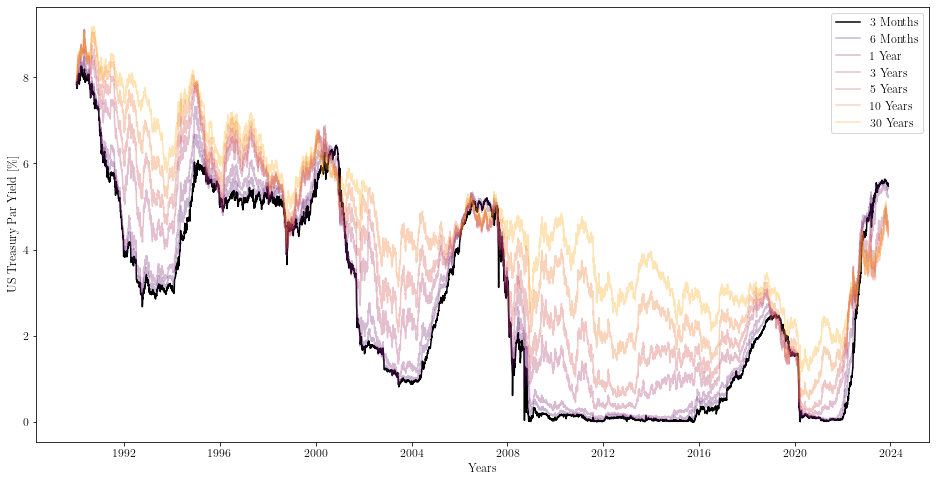

In [7]:
# Configure matplotlib to use LaTeX for rendering
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font', size=12)

# Specify colors
myMap = plt.get_cmap('inferno') # Paired, inferno
colors = myMap(np.linspace(0.1,0.8,7))

fig, ax = plt.subplots(figsize=(16,8))
ax.plot(rates['Date'], rates['3 Mo'], label='3 Months', alpha=1, color='black')
ax.plot(rates['Date'], rates['6 Mo'], label='6 Months', alpha=0.3, color=colors[1])
ax.plot(rates['Date'], rates['1 Yr'], label='1 Year', alpha=0.3, color=colors[2])
ax.plot(rates['Date'], rates['3 Yr'], label='3 Years', alpha=0.3, color=colors[3])
ax.plot(rates['Date'], rates['5 Yr'], label='5 Years', alpha=0.3, color=colors[4])
ax.plot(rates['Date'], rates['10 Yr'], label='10 Years', alpha=0.3, color=colors[5])
ax.plot(rates['Date'], rates['30 Yr'], label='30 Years', alpha=0.3, color=colors[6])
ax.set_xlabel('Years')
ax.set_ylabel('US Treasury Par Yield [\%]')
ax.legend()
plt.savefig('PlotsData/HistoricalYields.pdf')
plt.show()

The period from 2016 to and including 2023 looks interesting. For visualization, we also construct the yield curves.

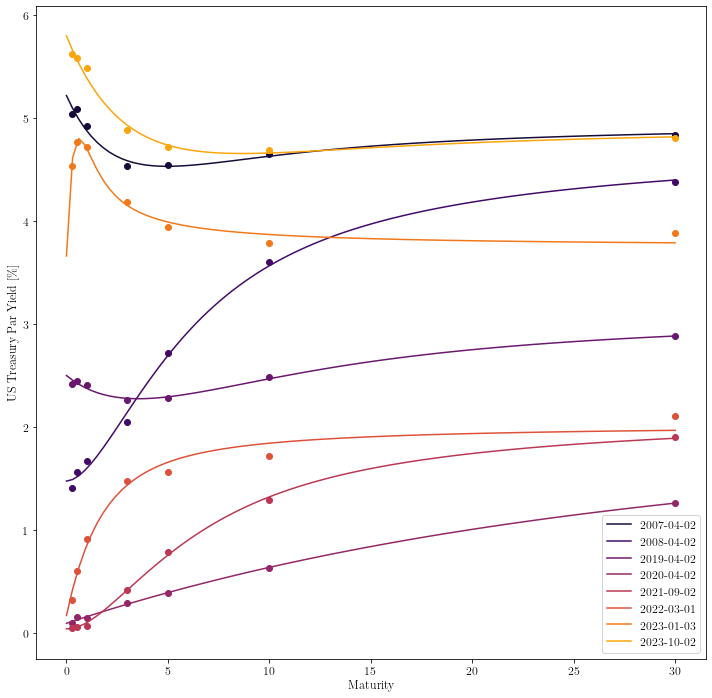

In [8]:
# Specify time for quotes
granularity = 100
t = np.array([3/12, 6/12, 1, 3, 5, 10, 30])
x = np.linspace(0,30,granularity)
curveDates = ['2007-04-02', '2008-04-02', '2019-04-02', '2020-04-02', '2021-09-02', '2022-03-01', '2023-01-03', '2023-10-02']

# Specify colors
myMap = plt.get_cmap('inferno') # Paired, inferno
colors = myMap(np.linspace(0.1,0.8,len(curveDates)))

# Configure matplotlib to use LaTeX for rendering
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font', size=12)

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(12,12))
ax.set_xlabel('Maturity')
ax.set_ylabel('US Treasury Par Yield [\%]')

for idx, date in enumerate(curveDates):

    # Fit the curve and add them 1 by one to the plot
    selectedQuotes = rates[rates['Date'] == date].iloc[0,:].values[1:]
    selectedQuotes = selectedQuotes.astype(np.float64)
    TS, status = calibrate_ns_ols(t, selectedQuotes, tau0=1.0)  # starting value of 1.0 for the optimization of tau
    ax.plot(x, TS(x), label=f'{date}', color=colors[idx])
    ax.scatter(t, selectedQuotes, color=colors[idx])
    
plt.savefig('PlotsData/SelectedYieldCurves.pdf')
plt.legend()
plt.show()

## 3) Animation

This section creates an animation for the yield curve in the period from January 2020 to November 2023. The curve are fitted to par yields.

In [9]:
runAnimation = False

if runAnimation:

    # Selected quotes
    animationRates = rates[rates['Date'] > '2020-01-01'].sort_values(by="Date", ascending=True)
    animationDates = animationRates['Date']
    animationRates = animationRates.drop(['Date'], axis=1)

    # Granularity
    granularity = 100

    # Specify time for quotes
    t = np.array([3/12, 6/12, 1, 3, 5, 10, 30])
    x = np.linspace(0,30,granularity)

    # Allocate memory for the results
    dynamicCurvesRaw = np.zeros((animationRates.shape[0], granularity))
    dynamicPointsRaw = np.zeros((animationRates.shape[0], animationRates.shape[1]))
    days, maturities = animationRates.shape

    # Recorded values
    recordedDates = []
    badDates = []
    recordedCurves = []

    # Save curves
    for i in range(days):

        # Get quotes and calibrate and generate curve
        quotes = np.array(animationRates.iloc[i,:].values, dtype=np.float64)
        try:
            TS, status = calibrate_ns_ols(t, quotes, tau0=1.2)  # starting value of 1.0 for the optimization of tau
            recordedDates.append(animationDates.values[i])
            dynamicCurvesRaw[i-len(badDates),:] = TS(x)
            dynamicPointsRaw[i-len(badDates),:] = quotes
        except:
            badDates.append(animationDates.values[i])
            continue

    # Save the full results
    dynamicCurves = np.copy(dynamicCurvesRaw[:-len(badDates),:])
    dynamicPointsRaw = np.copy(dynamicPointsRaw[:-len(badDates),:])

In [10]:
if runAnimation:

    # Configure matplotlib to use LaTeX for rendering
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    plt.rc('font', size=12)

    # Set up the figure and axis
    fig, ax = plt.subplots(figsize=(12,12))
    yield_curve, = ax.plot([], [], '-', color=colors[3])
    #yield_points, = ax.plot([], [], '-')
    ax.set_xlabel('Maturity')
    ax.set_ylabel('Yield Curve')

    # Function to initialize the plot
    def init():
        yield_curve.set_data([], [])
        return yield_curve,

    # Function to update the plot for each frame
    def update(frame):
        yield_curve.set_data(x, dynamicCurves[frame,:])
        #yield_points.set_data(x, dynamicCurves[frame,:])
        ax.set_title(str(recordedDates[frame])[:10])
        return yield_curve,

    # Set range
    plt.xlim(0, 30)
    plt.ylim(0, 10)

    # Tight layout
    plt.tight_layout()

    # Create the animation
    ani = FuncAnimation(fig=fig, func=update, init_func=init, frames=len(recordedDates), interval=100, repeat=False, blit=False)
    ani.save('DynamicYieldCurve.gif', writer='pillow', fps=100)

## 4) Testing DataLoader

In [15]:
dataLoader = DataLoader(path='./Data/')
rates = dataLoader.InterestRates(maturity="3 Mo", startDate="1999-01-01", endDate=dt.datetime.today().strftime("%Y-%m-%d"))

In [25]:
rates['3 Mo'] = (1 + rates['3 Mo']/100)**(1/63) - 1

In [26]:
rates

,Date,3 Mo
0,1999-01-04,0.000697
1,1999-01-05,0.000696
2,1999-01-06,0.000694
3,1999-01-07,0.000690
4,1999-01-08,0.000696
...,...,...
6228,2023-11-21,0.000855
6229,2023-11-22,0.000856
6230,2023-11-24,0.000856
6231,2023-11-27,0.000849


In [13]:
assets = dataLoader.SP500(freq="daily", startDate="1999-01-01", intersect=False, filtered=True, endDate=dt.datetime.today().strftime("%Y-%m-%d"))

In [14]:
assets

,Dates,SPX-INDEX,MWW,ED,PFE,COV,ORCL,LUMN,SVU,OGN,...,QRVO,CFG,EBAY,GM,AXP,ANR,A,CPT,FI,BRK-B
0,1999-11-01,1354.119995,NaN,11.713466,15.927703,NaN,10.492719,11.536110,98.384147,NaN,...,NaN,NaN,6.771823,NaN,31.429570,NaN,NaN,8.055430,5.156669,41.74
1,1999-11-02,1347.739990,NaN,11.618060,15.770495,NaN,10.863726,11.358675,100.761724,NaN,...,NaN,NaN,6.490075,NaN,31.113165,NaN,NaN,8.132658,5.166669,42.82
2,1999-11-03,1354.930054,NaN,11.695001,15.952526,NaN,11.747172,11.430222,100.761724,NaN,...,NaN,NaN,6.282472,NaN,31.007697,NaN,NaN,8.132658,5.188336,43.06
3,1999-11-04,1362.640015,NaN,11.581128,15.410570,NaN,11.927551,11.358675,102.806440,NaN,...,NaN,NaN,6.425817,NaN,30.860041,NaN,NaN,8.094044,5.250003,43.26
4,1999-11-05,1370.229980,NaN,11.658069,14.376304,NaN,12.030039,11.464564,100.143554,NaN,...,NaN,NaN,6.588934,NaN,31.598320,NaN,NaN,7.984143,5.375003,42.62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6047,2023-11-13,4411.549805,NaN,87.586080,28.980000,NaN,114.150000,1.150000,NaN,11.03,...,90.37,24.95,38.730000,26.90,154.340000,NaN,107.46,86.650000,121.560000,350.01
6048,2023-11-14,4495.700195,NaN,90.500000,29.260000,NaN,116.100000,1.300000,NaN,11.46,...,94.62,26.58,40.340000,28.20,156.910000,NaN,111.61,89.980000,122.160000,354.25
6049,2023-11-15,4502.879883,NaN,90.550000,30.190000,NaN,114.060000,1.380000,NaN,11.56,...,95.20,27.32,40.620000,28.14,159.430000,NaN,113.60,88.890000,125.240000,356.79
6050,2023-11-16,4508.240234,NaN,91.130000,29.770000,NaN,114.670000,1.380000,NaN,10.95,...,93.86,27.08,40.180000,27.48,159.050000,NaN,114.19,87.570000,124.830000,359.86
